In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-weather-surface-brazil-southeast-region/sudeste.csv


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams["patch.force_edgecolor"] = True


In [60]:
df_original = pd.read_csv("/kaggle/input/hourly-weather-surface-brazil-southeast-region/sudeste.csv", )
# df = pd.concat(df_original)

# Sample Data
Due to large data lets work with sampel data****

In [396]:
sample_df = df_original.sample(100000,random_state=101)

Dataset is too big so lets import in a chunk and work with the smallest one at first

## Info On Some Columns


1. Instant Air Temperature (celsius degrees) = temp
2. Maximum Air Temperature (celsius degrees) = tmin
3. Minimum Air Temperature (celsius degrees) = tmax
4. Relative Humidity of Air (%) =hmdy
5. Maximum Relative Air Humidity (%) =hmax
6. Minimum Relative Air Humidity (%) = hmin
7. Instant Dew Point (celsius degrees) = dewp
8. Maximum Dew Point (celsius degrees)=dmax
9. Minimum Dew Point Temperature (celsius degrees) = dmin
10. Instant Air Atmospheric Pressure (millibars) =stp
11. Maximum Air Atmospheric Pressure (millibars) = smax
12. Minimum Air Atmospheric Pressure (millibars)= smin
13. Instant Wind Speed (metres per second) = wdsp
14. Wind Direction (radius degrees) = wdct
15. Wind Gust Intensity (metres per second) = gust
16. Solar radiation  =  gbrd
17. Precipitation (milimetres) = prcp
18. Elevation = elvt
19. Observation Datetime = mdct
20. Observation Date = date
21. Station number (INMET number) for the location = inme
22. The year (2000-2016) : yr
23. The month (0-12) : mo
24. The day (0-31): da
25. The hour : hr

*Not all the columns are mentioned in this list*

In [397]:
# print(df.head())

In [398]:
print(sample_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 444352 to 5222905
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   wsid    100000 non-null  int64  
 1   wsnm    100000 non-null  object 
 2   elvt    100000 non-null  float64
 3   lat     100000 non-null  float64
 4   lon     100000 non-null  float64
 5   inme    100000 non-null  object 
 6   city    100000 non-null  object 
 7   prov    100000 non-null  object 
 8   mdct    100000 non-null  object 
 9   date    100000 non-null  object 
 10  yr      100000 non-null  int64  
 11  mo      100000 non-null  int64  
 12  da      100000 non-null  int64  
 13  hr      100000 non-null  int64  
 14  prcp    14488 non-null   float64
 15  stp     100000 non-null  float64
 16  smax    100000 non-null  float64
 17  smin    100000 non-null  float64
 18  gbrd    58007 non-null   float64
 19  temp    100000 non-null  float64
 20  dewp    99998 non-null   float64
 21  tmax

# Tidying Data

## Drop Elvt,Lat and Long

 Lat and long can correlate to city and province, so, remove elevation, longitude and lattitude 

In [399]:
# df.drop(['lat','lon', 'elvt'],inplace=True, axis=1)
sample_df.drop(['lat','lon', 'elvt'], axis=1,inplace=True)

In [400]:
print(sample_df.iloc[:,:10].head(1))
print("=="*20)
print(sample_df.iloc[:,10:20].head(1))
print("=="*20)

print(sample_df.iloc[:,20:].head(1))

        wsid        wsnm  inme        city prov                 mdct  \
444352   307  SÃO MATEUS  A616  São Mateus   ES  2009-09-10 16:00:00   

              date    yr  mo  da  
444352  2009-09-10  2009   9  10  
        hr  prcp     stp    smax    smin      gbrd  temp  dewp  tmax  dmax
444352  16   NaN  1017.7  1018.4  1017.7  2526.037  27.5  18.6  28.4  19.6
        tmin  dmin  hmdy  hmax  hmin  wdsp  wdct  gust
444352  26.9  18.0  58.0  63.0  55.0   4.6  92.0   7.7


In [401]:
#Drop the weather station name since its being represented as wsid


sample_df.drop('wsnm', axis=1,inplace=True)

## Drop Multiple Time related columns

There are five columns on time of observatoin. They are mdct, date,yr, month and hour, which are same but separated into several sctions. Among them Date and Hour columns are useful and represent all in some form, so others can be dropped. The conversion of date column to datetime gave format error. So, first lets combine the yr,mo,da and hr columns to make one and then drop them

In [402]:
sample_df['date']=pd.to_datetime(sample_df[['yr', 'mo', 'da','hr']].rename(columns={'yr': 'year','mo': 'month','da': 'day','hr':'hour'}))

In [403]:
sample_df.drop(['mdct','yr','da','mo'], axis= 1, inplace=True)

Reset Index as Date column and the check for duplicates data on same date in same city and remove them

In [404]:
sample_df.set_index('date',inplace=True,drop=True)

Since there is no null values,under the assumption that all the data from various weather stations are valid and true, lets not filter the time of operation of weather stations and drop the wsids and inme, only city adn prov are enough.

In [405]:
# df.drop(['wsid','inme'], inplace=True, axis=1)
sample_df.drop(['wsid','inme'],inplace=True, axis=1)

# Exploration and Manipulation

In [406]:
# print(sample_df['city'].unique())
# print(sample_df['city'].value_counts(normalize=True)*100)

Text(0.5, 1.0, 'Weather Data by Province')

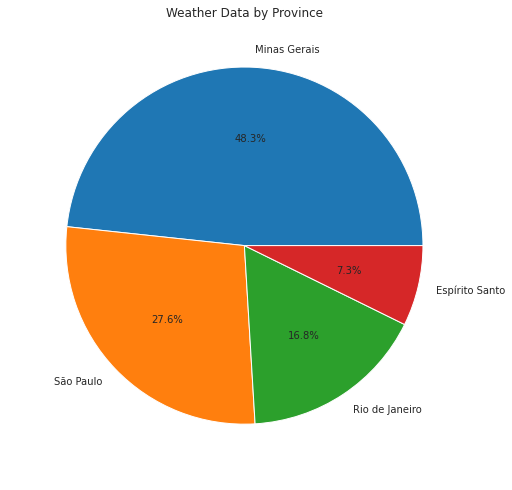

In [407]:
sample_df['prov'].value_counts(normalize=True).plot.pie(figsize=(8,10),autopct = '%.1f%%',labels=['Minas Gerais','São Paulo','Rio de Janeiro','Espírito Santo'])
plt.xlabel(" ")
plt.ylabel(" ")
# plt.legend(['Minas Gerais','São Paulo','Rio de Janeiro','Espírito Santo'], loc=0)
plt.title('Weather Data by Province')

In [408]:
sample_df.isnull().sum()

city        0
prov        0
hr          0
prcp    85512
stp         0
smax        0
smin        0
gbrd    41993
temp        0
dewp        2
tmax        1
dmax        4
tmin        0
dmin        9
hmdy        0
hmax        0
hmin        0
wdsp     9398
wdct        0
gust     3262
dtype: int64

## Missing Data Visualization Using Heatmap

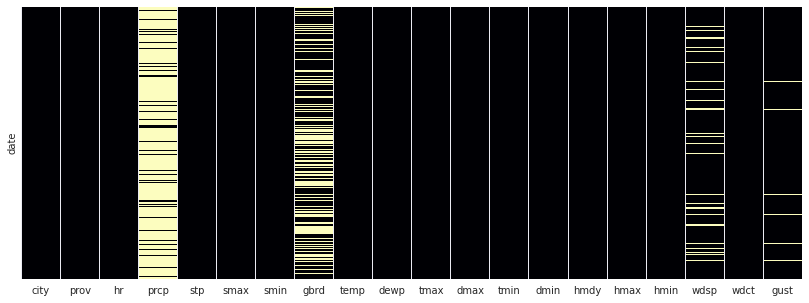

In [409]:
plt.figure(figsize=(14,5))
sns.heatmap(sample_df.isnull(),cmap='magma', cbar=False, yticklabels=False)

The figure shows that the prcp and gbrd have a lot of missing data. Lets check in actual percentage the amount of missing data. But heatmap cannot capture small percentage like tmin and tmax due to size difference.

## Missing data percentage calculation

Reutrn the columns with null values greater than 40% of total length of df.

 $((sample_df[col].isna().sum()*100) / df.shape[0])$ gives the null percentage of the relevant column.
 
  $sample_df[col].isna().sum() > round(0.4 * df.shape[0])$ checks if null percentage is more than 40% of toal length.Finally gives col and null percentage as key and value pair if the null amount is more thank 40 percentage

In [410]:


columns_40_percent_plus_null = {col:((sample_df[col].isna().sum()*100)/ sample_df.shape[0]) for col in sample_df.columns if sample_df[col].isna().sum() > 
                                round(0.4 * sample_df.shape[0]) }

In [411]:
columns_40_percent_plus_null

{'prcp': 85.512, 'gbrd': 41.993}

lets Drop both gbrd and prcp columns. And also nan rows from  temp,tmax,tmin columns since its really small.

In [412]:
sample_df.drop(['prcp','gbrd'], inplace=True,axis=1)

In [413]:
sample_df.dropna(subset=['tmax','temp','tmin'],inplace=True)

Just for the sake of argument fill the missing values in dewp, dmax with average values

In [414]:
sample_df['dmax'].fillna(sample_df['dmax'].mean(),inplace=True)
sample_df['dewp'].fillna(sample_df['dewp'].mean(),inplace=True)

### Windspeed and Gust Column missing vals

This [article](https://sciencing.com/winds-formed-5145233.html) suggests that wind-speed is affected by temperature and air pressure. So,lets find mean of windspeed between range of temp fill nans accordingly.

This [article](http://www.differencebetween.net/science/nature/difference-between-gust-and-wind/#:~:text=A%20gust%20is%20a%20sudden,comes%20in%202%2Dminute%20intervals.&text=A%20gust%20and%20wind%20both,earth's%20atmosphere%20around%20the%20earth.) suggest that gust is sudden change in windspeed due to terrain. So, using instant temperature to weighted mean to replace nans seems feaible for gust

In [423]:
print(sample_df['temp'].value_counts(bins=5).sort_index())


(-3.447, 5.82]     6623
(5.82, 15.04]      8143
(15.04, 24.26]    56291
(24.26, 33.48]    27821
(33.48, 42.7]      1121
Name: temp, dtype: int64


Instead of looping throuh ranges 5*5, 25 times for 10 intervals above, lets just use pair of ranges without inter-changing. *i.e first pair of temp interval with first pair of pressure interval*. And lets use the union instead of intersection. *i.e | instead of &*

In [416]:
# Create five ranges of mean according to above interval

first_range_mean= sample_df[((sample_df['temp']>=-3.447) & (sample_df['temp']<5.82)) ]['wdsp'].mean()
second_range_mean= sample_df[((sample_df['temp']>=5.82) & (sample_df['temp']<15.04))  ]['wdsp'].mean()
third_range_mean= sample_df[((sample_df['temp']>=15.04) & (sample_df['temp']<24.26))  ]['wdsp'].mean()
fourth_range_mean= sample_df[((sample_df['temp']>=24.26) & (sample_df['temp']<33.48))  ]['wdsp'].mean()
fifth_range_mean= sample_df[((sample_df['temp']>=33.48) & (sample_df['temp']<42.7)) ]['wdsp'].mean()

In [417]:
print(first_range_mean, second_range_mean,third_range_mean,fourth_range_mean,fifth_range_mean)

0.04393777642214428 1.8885478342162743 1.998070520277601 2.474517157322322 2.4622504537205057


Create a function to fill missing values

In [418]:
# this funciton will take two cols, temp and wdsp in this order
#math is imported to check nan, np.nan wont work
def fill_missing_temp(col):
    import math
#Initialize relevant cols
    temp = col[0]
    wdsp = col[1]
    
    # If the value is nan
    #Assign by ranges declared above
    if math.isnan(wdsp):
        if(temp<5.82):
            return first_range_mean
        elif(temp>=5.82) and (temp<15.04):
            return second_range_mean
        elif(temp>=15.04) and (temp<24.26):
            return third_range_mean
        elif(temp>=24.26) and (temp<33.48):
            return fourth_range_mean
        elif(temp>=33.48):
            return fifth_range_mean
        #if not nan return as it is
    else:
        return wdsp
    
    

In [419]:
sample_df['wdsp'] = sample_df[['temp','wdsp']].apply(fill_missing_temp,axis=1)
# sample_df[['temp','wdsp']].apply(fill_missing_temp)

In [421]:
#Check for  null again
sample_df['wdsp'].isnull().sum()

0

Lets repeat the same process of gust using instant temperature